In [1]:
# import os
# import re
# import json
# import math
import numpy as np
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
import torch
from torch.utils.data import Dataset, DataLoader
from my_utils import *
# from pathlib import Path
# from typing import Optional, Tuple, List
import torch
import pytorch_lightning as pl
from PIL import Image
from config import config
import albumentations as A
from albumentations.augmentations.geometric.rotate import SafeRotate

In [2]:
def load_from_pickle(fp):
    with open(fp, 'rb') as f:
        bin = f.read()
        obj = pickle.loads(bin)
    return obj


def generate_heatmap(size, center, radius):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.

    source: https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    """
    width, height = size
    x0, y0 = center
    radius_x, radius_y = radius

    x = np.arange(0, width, 1, float)
    y = np.arange(0, height, 1, float)[:,np.newaxis]
    heatmap = np.exp(-4*np.log(2) * ((x-x0)**2/radius_x**2 + (y-y0)**2/radius_y**2))
    return heatmap

In [3]:
class BallDataset(Dataset):
    def __init__(self, config, transforms, mode):
        super(BallDataset, self).__init__()
        self.config = config
        self.mode = mode
        self.n_input_frames = config.data.n_input_frames
        self.n_sample_limit = config.data.n_sample_limit
        self.input_w, self.input_h = config.data.input_size
        self.output_w, self.output_h = self.input_w // config.data.output_stride, self.input_h // config.data.output_stride
        self.ball_radius = (config.data.ball_radius[0] // config.data.output_stride, config.data.ball_radius[1] // config.data.output_stride)
        self.transforms = transforms
        self._init_paths_and_labels()
    

    def _init_paths_and_labels(self):
        if self.mode == 'train':
            data_dict_path = self.config.data.train_dict_path
        elif self.mode == 'val':
            data_dict_path = self.config.data.val_dict_path
        else:
            data_dict_path = self.config.data.test_dict_path

        data_dict = load_from_pickle(data_dict_path)
        self.ls_img_paths = sorted(data_dict.keys())[:int(self.n_sample_limit)]
        self.ls_ball_pos = [data_dict[img_paths] for img_paths in self.ls_img_paths]


    def __len__(self):
        return len(self.ls_ball_pos)
    

    def __getitem__(self, index):
        img_paths = self.ls_img_paths[index]
        normalized_pos = self.ls_ball_pos[index]
        abs_x, abs_y = normalized_pos[0] * self.output_w, normalized_pos[1] * self.output_h

        # process img
        input_imgs = [cv2.resize(cv2.imread(fp), (self.input_w, self.input_h)) for fp in img_paths]
        input_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in input_imgs]

        if self.transforms is not None and np.random.rand() < self.config.training.augment_prob:
            orig_pos = (abs_x*self.config.data.output_stride, abs_y*self.config.data.output_stride)
            transformed = self.transforms(
                image=input_imgs[0],
                image0=input_imgs[1],
                image1=input_imgs[2],
                image2=input_imgs[3],
                image3=input_imgs[4],
                keypoints=[orig_pos]
            )
            transformed_imgs = [transformed[k] for k in sorted([k for k in transformed.keys() if k.startswith('image')])]
            if len(transformed['keypoints']) > 0:
                orig_x, orig_y = transformed['keypoints'][0]
                abs_x, abs_y = orig_x / self.config.data.output_stride, orig_y / self.config.data.output_stride
                transformed_imgs = np.concatenate(transformed_imgs, axis=2)
                transformed_imgs = torch.tensor(transformed_imgs)
            else:
                transformed_imgs = torch.tensor(np.concatenate(input_imgs, axis=2))

        else:
            transformed_imgs = torch.tensor(np.concatenate(input_imgs, axis=2))

        # normalize
        transformed_imgs = transformed_imgs / 255.

        # process pos
        int_x, int_y = int(abs_x), int(abs_y)

        offset_x, offset_y = abs_x - int_x, abs_y - int_y
        heatmap = generate_heatmap(size=(self.output_w, self.output_h), center=(int_x, int_y), radius=self.ball_radius)
        heatmap = torch.tensor(heatmap)

        offset_map = torch.zeros(2, self.output_h, self.output_w)
        offset_map[0, int_y, int_x] = offset_x
        offset_map[1, int_y, int_x] = offset_y

        abs_pos = torch.tensor([int_x, int_y])

        return transformed_imgs.permute(2, 0, 1), heatmap, offset_map, abs_pos

In [5]:
config.training.augment_prob = 1
print(config.training.augment_prob)

1


In [20]:
transforms = A.Compose(
    # A.SomeOf([
    #     A.HorizontalFlip(p=0.5),
    #     A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.15, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, value=0),
    #     A.ColorJitter(p=0.5, brightness=0.15, contrast=0.15, saturation=0.15, hue=0.07, always_apply=False),
    #     A.SafeRotate(p=0.5, limit=10, border_mode=cv2.BORDER_CONSTANT, value=0),
    # ], n=2),
    [
        A.ColorJitter(p=1, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, always_apply=False),
    ],
    additional_targets={'image0': 'image', 'image1': 'image', 'image2': 'image', 'image3': 'image'},
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=True)
)
ds = BallDataset(config, transforms, 'train')
for i, item in enumerate(ds):
    if i == 0:
        print('ok')
        imgs, hm, om, pos = item
        break
print(imgs.shape)
print(hm.shape)
print(om.shape)
print(pos.shape)

ok
torch.Size([15, 512, 512])
torch.Size([512, 512])
torch.Size([2, 512, 512])
torch.Size([2])


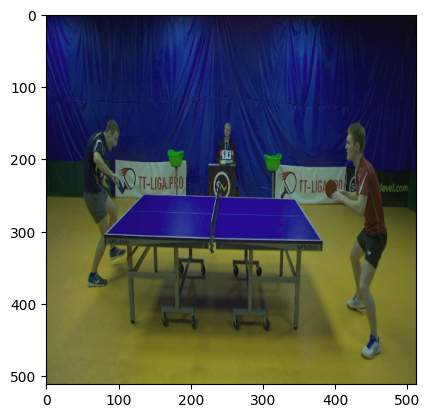

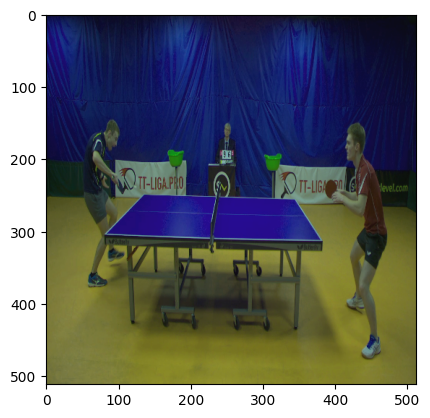

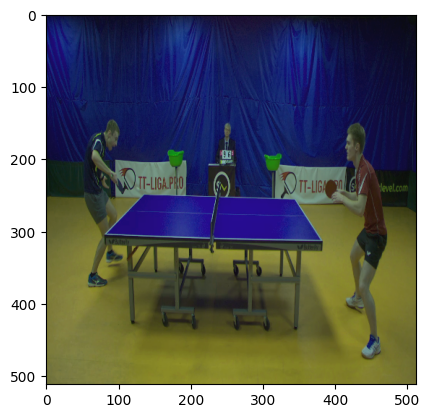

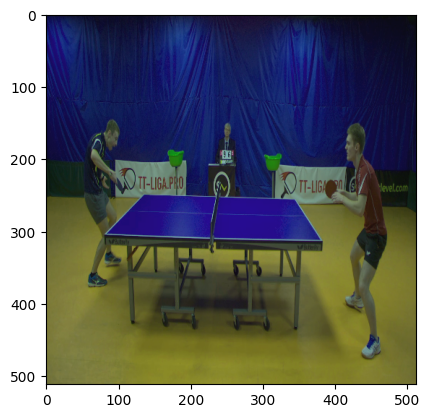

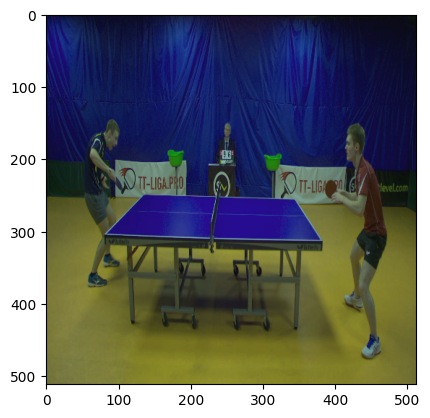

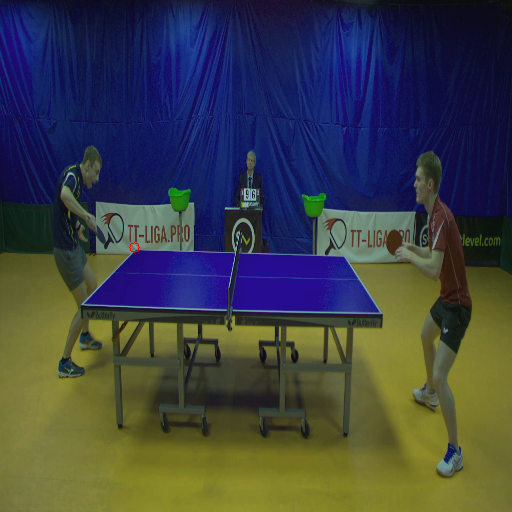

In [21]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2

pos = pos * config.data.output_stride

imgs = imgs.permute(1, 2, 0).detach().cpu().numpy()
imgs = np.array(np.split(imgs, 5, axis=2))
imgs = (imgs * 255).astype(np.uint8)
for img in imgs:
    plt.imshow(img)
    plt.show()

img = cv2.circle(img, (pos[0].item(), pos[1].item()), radius=5, color=(255, 0, 0), thickness=1)
Image.fromarray(img)

In [17]:
ds.ls_img_paths[0]

('/data/tungtx2/datn/ttnet/dataset/train/images/game_1/img_000010.jpg',
 '/data/tungtx2/datn/ttnet/dataset/train/images/game_1/img_000011.jpg',
 '/data/tungtx2/datn/ttnet/dataset/train/images/game_1/img_000012.jpg',
 '/data/tungtx2/datn/ttnet/dataset/train/images/game_1/img_000013.jpg',
 '/data/tungtx2/datn/ttnet/dataset/train/images/game_1/img_000014.jpg')

In [103]:
imgs = np.array(np.split(imgs, 5, axis=2))
imgs = imgs * 255
imgs = imgs.astype(np.uint8)

hm = (hm*255).astype(np.uint8)

print(imgs.shape)
print(hm.shape)

(5, 512, 512, 3)
(512, 512)


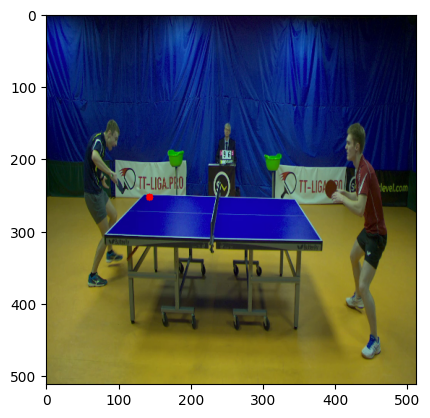

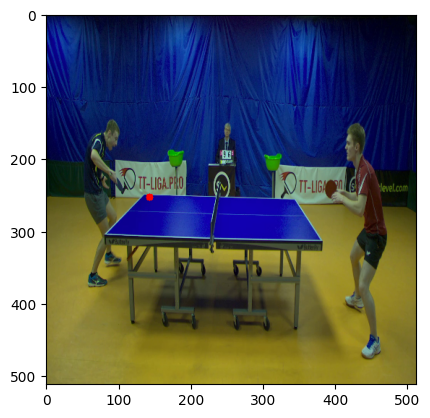

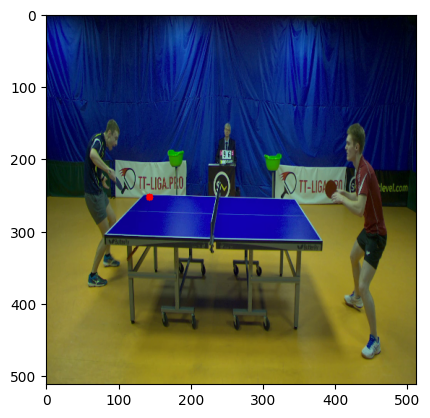

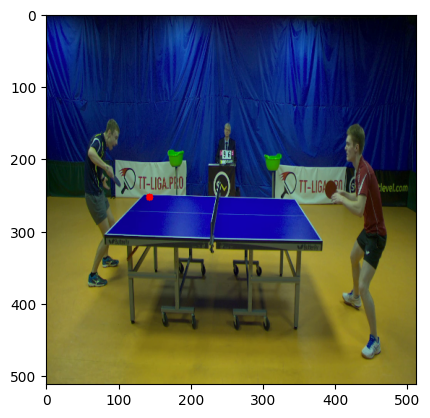

In [104]:
for img in imgs:
    drawed = cv2.circle(img, pos, 5, (255, 0, 0), -1)
    plt.imshow(drawed)
    plt.show()

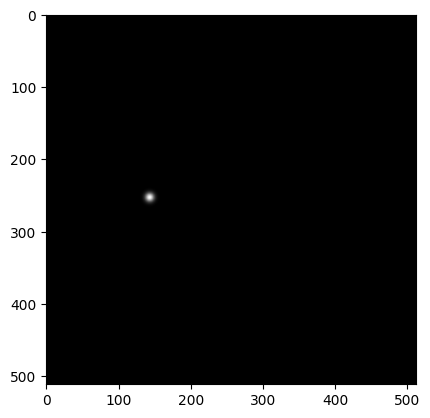

True

In [105]:
plt.imshow(hm, cmap='gray')
plt.show()
cv2.imwrite('test.jpg', hm)

In [107]:
np.where(hm==255)

(array([253]), array([143]))

In [94]:
np.where(hm!=0)

(array([105, 105, 105, ..., 431, 431, 431]),
 array([154, 155, 156, ..., 186, 187, 188]))

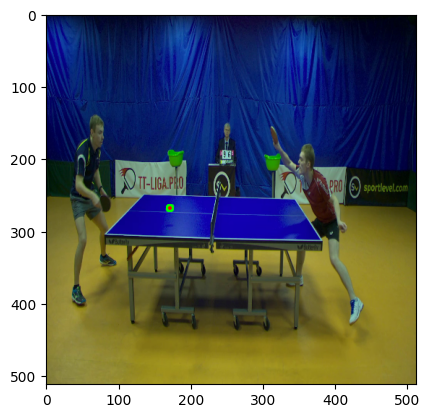

In [38]:
hm_int = (hm * 255).astype(np.uint8)
ret, thresh = cv2.threshold(hm_int, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
contour_img = cv2.drawContours(img, [largest_contour], 0, (0, 255, 0), 2)
plt.imshow(contour_img)
plt.show()

In [31]:
print(om.shape)
print(np.where(om[:, :, 0]!=0))
print(np.where(om[:, :, 1]!=0))

(512, 512, 2)
(array([253]), array([143]))
(array([253]), array([143]))
[0.         0.15555556 0.2       ]


# Debug Loss

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pdb


class CustomFocalLoss(nn.Module):
    def __init__(self, alpha=2, beta=4, pos_weight=0.4, eps=1e-5):
        """
            set alpha = 0 and we have standard BCE loss
            set pos_weight < 0.5 will penalty false positive more 
        """
        super(CustomFocalLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.pos_weight = pos_weight
        self.neg_weight = 1 - self.pos_weight
        self.eps = eps


    def forward(self, ypred: torch.tensor, ytrue: torch.tensor):
        """
            Y_true: tensor, shape n x 128 x 128, 
            y_pred: tensor, shape n x 1 x 128 x 128 
        """
        # pdb.set_trace()
        ypred = torch.squeeze(ypred, dim=1)
        class_weight_mask = torch.where(ytrue!=0, torch.tensor(self.pos_weight), torch.tensor(self.neg_weight))
        
        loss1 = ytrue.eq(1).float() * (1-ypred)**self.alpha * torch.log(ypred+self.eps)
        loss2 = ytrue.ne(1).float() * (1-ytrue)**self.beta * ypred**self.alpha * torch.log(1-ypred+self.eps)
        loss = loss1 + loss2
        loss = class_weight_mask * loss
        # pdb.set_trace()
        return -1 / ypred.shape[0] * loss.sum()

In [86]:
criterion = CustomFocalLoss(alpha=2, beta=4, pos_weight=0.4)
pred = torch.tensor([
    [0.9, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0.1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
]).unsqueeze(0).unsqueeze(0)

true = torch.tensor([
    [0, 0, 0, 0, 0],
    [0, 0.8, 0.8, 0.8, 0],
    [0, 0.7, 1.0, 0.7, 0],
    [0, 0.8, 0.7, 0.8, 0],
    [0, 0, 0, 0, 0],
]).unsqueeze(0)

# true = torch.tensor([
#     [0, 0, 0, 0, 0],
#     [0, 0., 0, 0, 0],
#     [0, 0, 1, 0, 0],
#     [0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0],
# ]).unsqueeze(0)

print(pred.shape, true.shape)
loss = criterion(pred, true)
print('loss: ', loss)

torch.Size([1, 1, 5, 5]) torch.Size([1, 5, 5])
loss:  tensor(1.8650)


In [61]:
torch.log(torch.tensor(1+1e-5))

tensor(1.0014e-05)

In [ ]:
import torch

# create two tensors of the same shape
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[5, 6], [7, 8]])

# method 1: use torch.mul()
c = torch.mul(a, b)

# method 2: use the multiplication operator *
d = a * b

print(c)
print(d)

# Infer